<a href="https://colab.research.google.com/github/GhogareS13/segmentation_model/blob/main/Segmentation_Use_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q segmentation-models-pytorch
!pip install -q albumentations

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.8 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()


Saving custom_dataset.zip to custom_dataset.zip


In [3]:
import zipfile
with zipfile.ZipFile("custom_dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [4]:
import os
import torch.optim as optim
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".jpg", ".png").replace(".jpeg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Grayscale mask

        if self.transform:
            image = self.transform(image)
            mask = T.ToTensor()(mask)  # 1 channel

        return image, mask


In [5]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

dataset = SegmentationDataset("/content/images", "/content/masks", transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [6]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=2), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
model.train()

for epoch in range(epochs):
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 1/10, Loss: 0.5089
Epoch 2/10, Loss: 0.2578
Epoch 3/10, Loss: 0.1695
Epoch 4/10, Loss: 0.0764
Epoch 5/10, Loss: 0.0609
Epoch 6/10, Loss: 0.0169
Epoch 7/10, Loss: 0.0248
Epoch 8/10, Loss: 0.0288
Epoch 9/10, Loss: 0.0445
Epoch 10/10, Loss: 0.0342


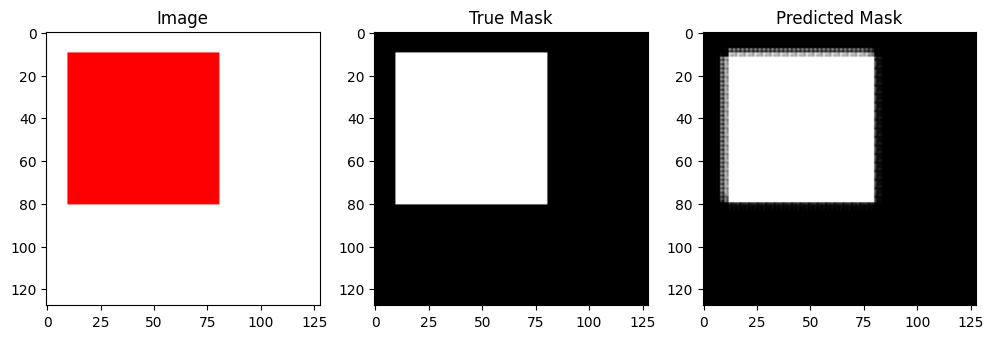

In [8]:
model.eval()
with torch.no_grad():
    img, true_mask = dataset[0]
    pred_mask = model(img.unsqueeze(0).to(device)).squeeze().cpu()

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)); plt.title("Image")
    plt.subplot(1,3,2); plt.imshow(true_mask.squeeze(), cmap="gray"); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap="gray"); plt.title("Predicted Mask")
    plt.show()
